### Import libraries and load csv file


In [1065]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from datetime import date

In [1066]:
av_df = pd.read_csv('avocado.csv', parse_dates=['Date'])
av_df = av_df.rename(columns = {'Date' : 'date', 'AveragePrice' : 'avg_price', 'Total Volume' : 'total_volume', '4046' : 'small_av', '4225' : 'large_av', '4770' : 'xlarge_av', 'Total Bags' : 'total_bags', 'Small Bags' : 'small_bags', 'Large Bags':'large_bags', 'XLarge Bags' : 'xlarge_bags'})
av_df = av_df.drop(columns = ['Unnamed: 0'])
av_df.tail()

,date,avg_price,total_volume,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


### Explore data section

In [1067]:
av_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
date            18249 non-null datetime64[ns]
avg_price       18249 non-null float64
total_volume    18249 non-null float64
small_av        18249 non-null float64
large_av        18249 non-null float64
xlarge_av       18249 non-null float64
total_bags      18249 non-null float64
small_bags      18249 non-null float64
large_bags      18249 non-null float64
xlarge_bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


### Data cleaning

#### Check and change data types

In [1083]:
# If there is a date greater than today's date we will assign it to today's date
av_df['date'].max()

# today = date.today()
# av_df.loc[av_df['date'] > today, 'date'] = today

Timestamp('2018-03-25 00:00:00')

In [1069]:
#change avocado type to categorical variable

av_df['type'] = av_df['type'].astype('category')
av_df['type'].dtype

CategoricalDtype(categories=['conventional', 'organic'], ordered=False)

#### Duplicates checking

In [1070]:
# Check if there are duplicates
columns = ['date', 'total_volume', 'region']
duplicates = av_df.duplicated(subset = columns, keep = False)
assert av_df[duplicates]['date'].count() == 0

# As we can see there are no duplicates

In [1071]:
av_df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [1072]:
# region = TotalUS is not a region description but summary information. Therefore, I'll delete these rows

av_df = av_df[av_df['region'] != 'TotalUS']
av_df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'West', 'WestTexNewMexico'], dtype=object)

### Check for consistency

In [1073]:
av_df.head(2)

,date,avg_price,total_volume,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany


In [1074]:
# check for consistency
total_bags_equ = av_df.total_bags == (av_df.small_bags+av_df.large_bags+av_df.xlarge_bags)
inconsistent_bags = av_df[~total_bags_equ]
consistent_bags = av_df[total_bags_equ]

total_volume_equ = av_df['total_volume'] == av_df['total_bags'] + av_df['small_av'] + av_df['large_av'] + av_df['xlarge_av']
inconsistent_volume = av_df[~total_volume_equ]
consistent_volume = av_df[total_volume_equ]

print(
    'consistent bags: ', consistent_bags.shape[0], 
    '\ninconsistent bags: ', inconsistent_bags.shape[0], 
    '\n\nconsistent volume: ', consistent_volume.shape[0], 
    '\ninconsistent volume:', inconsistent_volume.shape[0], 
    '\n\ntotal volume: ', av_df['total_volume'].sum())

consistent bags:  13967 
inconsistent bags:  3944 

consistent volume:  12051 
inconsistent volume: 5860 

total volume:  9658662411.599998


In [1075]:
# Number of avocado sold couldn't be a float. Due to rounding operation we see a lot of values with inconsistency. Therefore I decided to convert values to integer (but before I'll round them to avoid big influence).

float_columns = ['total_volume', 'small_av', 'large_av', 'xlarge_av', 
                 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags']
av_df[float_columns] = av_df[float_columns].round(0).astype('int')

# Let's check 'total volume value' after rounding:
total_vol = av_df['total_volume'].sum()

print('Total volume: ', total_vol, '\n\nValues types:\n', av_df.dtypes)

Total volume:  9658662389 

Values types:
 date            datetime64[ns]
avg_price              float64
total_volume             int64
small_av                 int64
large_av                 int64
xlarge_av                int64
total_bags               int64
small_bags               int64
large_bags               int64
xlarge_bags              int64
type                  category
year                     int64
region                  object
dtype: object


In [1076]:
# For further analyses the most important columns are totals. Therefore I don't want to influence on them while eliminating inconsistence. So, I will recalculate amounts of small avocados sold and small bags sold.

av_df['small_bags'] = av_df['total_bags'] - av_df['large_bags'] - av_df['xlarge_bags']
av_df['small_av'] = av_df['total_volume'] - av_df['large_av'] - av_df['xlarge_av'] - av_df['total_bags']

In [1077]:
# Let's check inconsistency once more
total_bags_equ = av_df.total_bags == (av_df.small_bags+av_df.large_bags+av_df.xlarge_bags)
inconsistent_bags = av_df[~total_bags_equ]

total_volume_equ = av_df['total_volume'] == av_df['total_bags'] + av_df['small_av'] + av_df['large_av'] + av_df['xlarge_av']
inconsistent_volume = av_df[~total_volume_equ]
print('inconsistent bags: ', inconsistent_bags.shape[0], 
      '\ninconsistent volume:', inconsistent_volume.shape[0],
      '\ntotal volume change: ', av_df.total_volume.sum() - total_vol)

inconsistent bags:  0 
inconsistent volume: 0 
total volume change:  0


### Analysing price

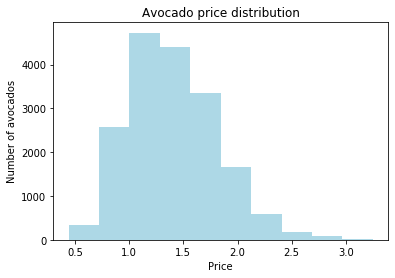

In [1078]:
# Analysing price distribution
_ = plt.hist(av_df.avg_price, color = 'lightblue')

plt.xlabel('Price')
plt.ylabel('Number of avocados')
plt.title('Avocado price distribution')
plt.show()

In [1079]:
# Let's group regions by average price categories
# According to the histogram, we can devide our data by 3 categories

category_ranges = [0, 1, 2, np.inf]
category_names = ['Low', 'Medium', 'High']

av_df['price_category'] = pd.cut(av_df.avg_price, bins = category_ranges, labels = category_names)
av_df.head()

,date,avg_price,total_volume,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,price_category
0,2015-12-27,1.33,64237,1037,54455,48,8697,8604,93,0,conventional,2015,Albany,Medium
1,2015-12-20,1.35,54877,674,44639,58,9506,9409,97,0,conventional,2015,Albany,Medium
2,2015-12-13,0.93,118220,795,109150,130,8145,8042,103,0,conventional,2015,Albany,Low
3,2015-12-06,1.08,78992,1132,71976,73,5811,5677,134,0,conventional,2015,Albany,Medium
4,2015-11-29,1.28,51040,942,43838,76,6184,5986,198,0,conventional,2015,Albany,Medium


In [1086]:
av_df[av_df['avg_price'] > 3]

,date,year,region,type,avg_price,price_category,total_volume,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
13037,2016-10-02,2016,LasVegas,organic,3.03,High,3715,297,2700,0,718,718,0,0
14124,2016-11-06,2016,SanFrancisco,organic,3.12,High,19044,5899,10039,0,3106,3079,27,0
14125,2016-10-30,2016,SanFrancisco,organic,3.25,High,16701,2326,11143,0,3232,3232,0,0
16055,2017-03-12,2017,MiamiFtLauderdale,organic,3.05,High,2068,1044,77,0,947,927,20,0
16720,2017-08-27,2017,RaleighGreensboro,organic,3.04,High,12656,419,4852,145,7240,6961,279,0
17428,2017-04-16,2017,Tampa,organic,3.17,High,3019,1256,82,0,1681,1543,138,0


In [1080]:
# Ordering columns
# At first we could get list of columns names
av_df.columns

Index(['date', 'avg_price', 'total_volume', 'small_av', 'large_av',
       'xlarge_av', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type', 'year', 'region', 'price_category'],
      dtype='object')

In [1081]:
# Ordering columns
# At first we could get list of columns names
av_df.columns

col_list = ['date', 'year', 'region', 'type', 'avg_price', 'price_category', 'total_volume', 'small_av', 'large_av', 'xlarge_av', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags']
av_df = av_df.reindex(columns=col_list)
av_df.head(2)

,date,year,region,type,avg_price,price_category,total_volume,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
0,2015-12-27,2015,Albany,conventional,1.33,Medium,64237,1037,54455,48,8697,8604,93,0
1,2015-12-20,2015,Albany,conventional,1.35,Medium,54877,674,44639,58,9506,9409,97,0


In [1087]:
av_df.to_csv('avocado_cleaned.csv')